In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle
import pmdarima as pm
from sklearn.preprocessing import StandardScaler

## 1) Importing Data 

In [28]:
sp500=yf.download('^NSEI',start="2011-01-01", end="2015-12-31",interval='1d')

[*********************100%***********************]  1 of 1 completed


In [29]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,6177.450195,6178.549805,6147.200195,6157.600098,6157.600098,0
2011-01-04,6172.750000,6181.049805,6124.399902,6146.350098,6146.350098,0
2011-01-05,6141.350098,6141.350098,6062.350098,6079.799805,6079.799805,0
2011-01-06,6107.000000,6116.149902,6022.299805,6048.250000,6048.250000,0
2011-01-07,6030.899902,6051.200195,5883.600098,5904.600098,5904.600098,0


In [30]:
sp500['Returns %']=sp500['Adj Close'].diff() / sp500['Adj Close']

In [31]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,Returns %
Date,,,,,,,
2011-01-03,6177.450195,6178.549805,6147.200195,6157.600098,6157.600098,0,NaN
2011-01-04,6172.750000,6181.049805,6124.399902,6146.350098,6146.350098,0,-0.001830
2011-01-05,6141.350098,6141.350098,6062.350098,6079.799805,6079.799805,0,-0.010946
2011-01-06,6107.000000,6116.149902,6022.299805,6048.250000,6048.250000,0,-0.005216
2011-01-07,6030.899902,6051.200195,5883.600098,5904.600098,5904.600098,0,-0.024328


<AxesSubplot:xlabel='Date'>

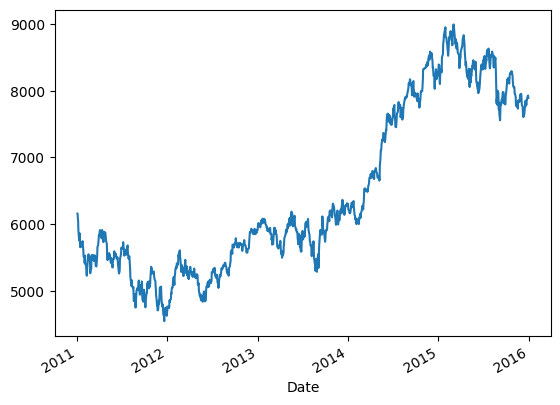

In [32]:
sp500['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

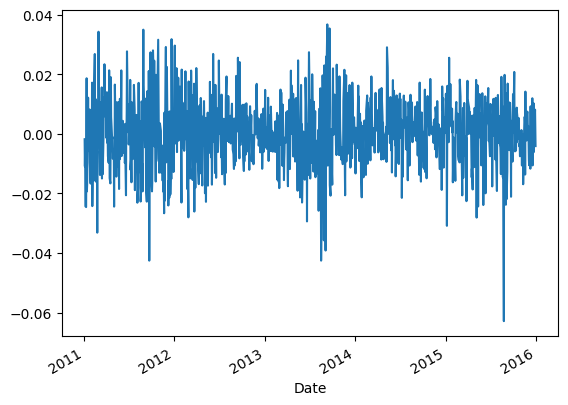

In [33]:
sp500['Returns %'].plot()

In [34]:
# sp500['Adj Close'].ewm(span=100).mean().plot()

In [35]:
# sp500['Adj Close']=sp500['Adj Close'].ewm(span=80).mean()

<AxesSubplot:xlabel='Date'>

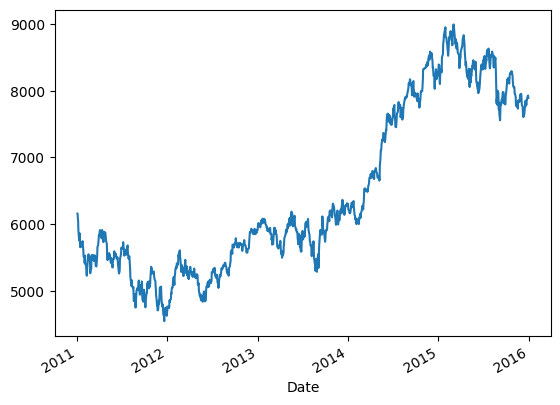

In [36]:
sp500['Adj Close'].plot()

The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. An example of a cyclical pattern is the cycles of boom and bust that stock markets experience in response to world events. <br>
This data seems to have cyclical component with no consistent cyclicity. So instead of decomposing it into trend, seasonality, noise, we would just keep it as it is.

In [37]:
sp500['Adj Close'].shape

(1214,)

Figure(640x480)


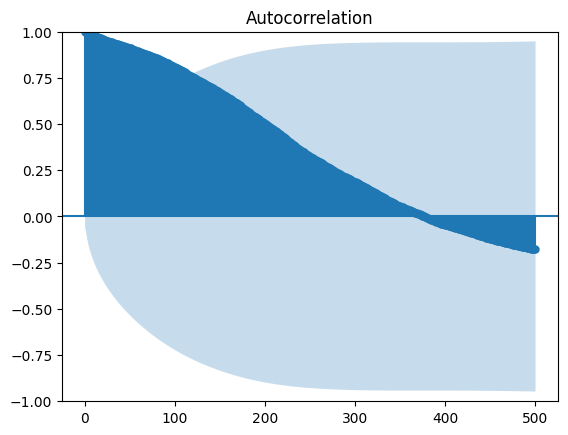

In [38]:
print(plot_acf(sp500['Adj Close'],lags=500))

Also autocorrelation graph shows no seasonal pattern.

## 4) Model

In [13]:
'''sar = sm.tsa.statespace.SARIMAX(sp500.loc[~np.isnan(np.array(sp500['Log Returns %'])),'Log Returns %'], 
                                order=(1,0,1), 
                                seasonal_order=(0,0,0,0), 
                                trend='c').fit()
sar.summary()

# sarima model without seasonality is arima model '''

"sar = sm.tsa.statespace.SARIMAX(sp500.loc[~np.isnan(np.array(sp500['Log Returns %'])),'Log Returns %'], \n                                order=(1,0,1), \n                                seasonal_order=(0,0,0,0), \n                                trend='c').fit()\nsar.summary()\n\n# sarima model without seasonality is arima model "

In [17]:
# non seasonal
pm.auto_arima(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),start_p=1, start_q=1,
                           max_p=3, max_q=3, m=55, 
                           start_P=1, D=0, start_Q=1, max_P=3, max_D=0, max_Q=3,
                               seasonal=False,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (55) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7551.319, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7544.629, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7552.614, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7553.116, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-7551.431, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7550.498, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7551.185, Time=0.20 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.935 seconds


ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [80]:
# seasonal
pm.auto_arima(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),start_p=1, start_q=1,
                           max_p=3, max_q=3, m=55, 
                           start_P=1, D=0, start_Q=1, max_P=3, max_D=0, max_Q=3,
                               seasonal=True,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[55] intercept   : AIC=-7546.607, Time=25.48 sec
 ARIMA(0,0,0)(0,0,0)[55] intercept   : AIC=-7542.712, Time=0.64 sec
 ARIMA(1,0,0)(1,0,0)[55] intercept   : AIC=-7549.938, Time=18.07 sec
 ARIMA(0,0,1)(0,0,1)[55] intercept   : AIC=-7550.338, Time=19.65 sec
 ARIMA(0,0,0)(0,0,0)[55]             : AIC=-7544.629, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[55] intercept   : AIC=-7551.185, Time=1.02 sec
 ARIMA(0,0,1)(1,0,0)[55] intercept   : AIC=-7550.468, Time=14.69 sec
 ARIMA(0,0,1)(1,0,1)[55] intercept   : AIC=-7548.384, Time=22.00 sec
 ARIMA(1,0,1)(0,0,0)[55] intercept   : AIC=-7549.389, Time=2.30 sec
 ARIMA(0,0,2)(0,0,0)[55] intercept   : AIC=-7549.501, Time=2.97 sec
 ARIMA(1,0,0)(0,0,0)[55] intercept   : AIC=-7550.683, Time=0.90 sec
 ARIMA(1,0,2)(0,0,0)[55] intercept   : AIC=-7548.581, Time=1.52 sec
 ARIMA(0,0,1)(0,0,0)[55]             : AIC=-7553.116, Time=0.71 sec
 ARIMA(0,0,1)(1,0,0)[55]             : AIC=-7552.389, Time=6.04 sec


ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 55),
      suppress_warnings=True, with_intercept=False)

In [39]:
sar = sm.tsa.statespace.SARIMAX(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1), 
                                order=(1,0,1), 
                                seasonal_order=(1,0,0,45), 
                                trend='c').fit()
sar.summary()

# sarima model without seasonality is arima model

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Returns %   No. Observations:                 1213
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 45)   Log Likelihood                3780.008
Date:                             Fri, 10 Mar 2023   AIC                          -7550.017
Time:                                     01:57:21   BIC                          -7524.513
Sample:                                          0   HQIC                         -7540.415
                                            - 1213                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.784e-05      0.000      0.238      0.812      -0.001       0.001
ar.L1         -0.0961      0.278     -0.345      0.730      -0.641       0.449
ma.L1          0.1878      0.273      0.688      0.492      -0.348       0.723
ar.S.L45       0.0446      0.028      1.578      0.114      -0.011       0.100
sigma2         0.0001   3.43e-06     33.487      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               189.34
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
import matplotlib.pyplot as plt
sar.plot_diagnostics(lags=12,figsize = (20,10),)
plt.savefig('ppt_pics/residual_diag_nifty_11_15.png')

NameError: name 'sar' is not defined

In [1]:
# plots(sar.resid[sar.loglikelihood_burn:], lags=12);

In [2]:
'''with open('nifty_08_12.pkl', 'wb') as f:
    pickle.dump(sar, f) '''

"with open('nifty_08_12.pkl', 'wb') as f:\n    pickle.dump(sar, f) "

In [3]:
'''with open('nifty_08_12.pkl', 'rb') as f:
    sar = pickle.load(f) '''

"with open('nifty_08_12.pkl', 'rb') as f:\n    sar = pickle.load(f) "

In [4]:
np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1)[1150:].plot(legend=True)
sar.predict(start=1150).plot(legend=True, xlabel='Time Period',ylabel='Log Returns % Difference')
# sar.predict(start=1150,dynamic=True).plot(legend=True)
# sar.forecast(steps=100).plot()
# sp500[730:][['Adj Close', 'Adj Close Forecast']].plot();

NameError: name 'np' is not defined

In [20]:
def accuracy_sarimax(df1,df2):
    x=np.sign(np.array(df1))==np.sign(np.array(df2))
    
    return sum(x) / len(x)

In [5]:
accuracy_sarimax(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),sar.predict())

NameError: name 'accuracy_sarimax' is not defined

In [87]:
# sp500_fore=yf.download('^NSEI',start="2016-01-01", end="2016-05-15",interval='1d')
# sp500_fore['Adj Close']

In [88]:
# sp500_fore['Returns %']=sp500_fore['Adj Close'].diff() / sp500_fore['Adj Close']

In [89]:
# np.log(sp500_fore.loc[~np.isnan(np.array(sp500_fore['Returns %'])),'Returns %']+1)

In [90]:
# np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1).append(sp500_fore['Adj Close'])